In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style='whitegrid')

np.random.seed(42)

import torch
import torch.nn as nn

In [6]:
torch.manual_seed(87) 
player_cleaned_df = pd.read_csv('../data/cleaned/player_attributes_cleaned.csv')
player_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   height               177037 non-null  float64
 2   weight               177037 non-null  float64
 3   date                 177037 non-null  object 
 4   age                  177037 non-null  float64
 5   overall_rating       177037 non-null  float64
 6   potential            177037 non-null  float64
 7   preferred_foot       177037 non-null  float64
 8   attacking_work_rate  177037 non-null  float64
 9   defensive_work_rate  177037 non-null  float64
 10  crossing             177037 non-null  float64
 11  finishing            177037 non-null  float64
 12  heading_accuracy     177037 non-null  float64
 13  short_passing        177037 non-null  float64
 14  volleys              177037 non-null  float64
 15  dribbling        

In [7]:
player_cleaned_df = player_cleaned_df.drop(columns=['date'])
player_cleaned_df.head(20)
player_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177037 entries, 0 to 177036
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        177037 non-null  int64  
 1   height               177037 non-null  float64
 2   weight               177037 non-null  float64
 3   age                  177037 non-null  float64
 4   overall_rating       177037 non-null  float64
 5   potential            177037 non-null  float64
 6   preferred_foot       177037 non-null  float64
 7   attacking_work_rate  177037 non-null  float64
 8   defensive_work_rate  177037 non-null  float64
 9   crossing             177037 non-null  float64
 10  finishing            177037 non-null  float64
 11  heading_accuracy     177037 non-null  float64
 12  short_passing        177037 non-null  float64
 13  volleys              177037 non-null  float64
 14  dribbling            177037 non-null  float64
 15  curve            

In [8]:
import numpy as np
import torch

# Define which columns to use as input features
feature_cols = [col for col in player_cleaned_df.columns if col not in ['overall_rating', 'player_api_id']]
sequence_length = 3

X_list = []
y_list = []

# Group data by player
for _, group in player_cleaned_df.groupby('player_api_id'):
    group = group.reset_index(drop=True)
    if len(group) <= sequence_length:
        continue

    for i in range(len(group) - sequence_length):
        X_seq = group.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
        y_val = group.loc[i + sequence_length, 'overall_rating']  # <== here's the `y_val` you mentioned
        X_list.append(X_seq)
        y_list.append(y_val)

# Convert to PyTorch tensors
X_tensor = torch.tensor(np.stack(X_list))           # Shape: (samples, seq_len, features)
y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(1)  # Shape: (samples, 1)


In [9]:
import torch.nn as nn

class PlayerRatingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        last_output = out[:, -1, :]  # Take the last time step
        return self.fc(last_output)


In [10]:
# def custom_player_mse_loss(model, X_tensor, y_tensor, player_cleaned_df, feature_cols, sequence_length, device):
#     """
#     Custom loss function that computes MSE per player and sums across all players.
#     """
#     model.eval()
#     total_loss = 0.0
#     player_count = 0
    
#     # Group by player_api_id
#     for player_id, group in player_cleaned_df.groupby('player_api_id'):
#         group = group.reset_index(drop=True)
#         if len(group) <= sequence_length:
#             continue
            
#         # Prepare sequences for this player
#         X_player = []
#         y_player = []
        
#         for i in range(len(group) - sequence_length):
#             X_seq = group.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
#             y_val = group.loc[i + sequence_length, 'overall_rating']
#             X_player.append(X_seq)
#             y_player.append(y_val)
        
#         if len(X_player) == 0:
#             continue
            
#         # Convert to tensors and predict
#         X_player_tensor = torch.tensor(np.stack(X_player)).to(device)
#         y_player_tensor = torch.tensor(y_player, dtype=torch.float32).to(device)
        
#         with torch.no_grad():
#             preds = model(X_player_tensor).squeeze()
        
#         # Compute MSE for this player
#         player_mse = torch.mean((preds - y_player_tensor) ** 2)
#         total_loss += player_mse
#         player_count += 1
    
#     return total_loss, player_count

In [11]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        return torch.mean((predictions - targets)[3:] ** 2)

In [12]:
from torch.utils.data import TensorDataset, DataLoader

# Train/val split
train_ratio = 0.1
n_total = X_tensor.shape[0]
n_train = int(n_total * train_ratio)

X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlayerRatingLSTM(input_size=X_tensor.shape[2]).to(device)
loss_fn = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [13]:
# # Alternative: Use custom loss for training too (slower but matches your exact requirements)
# def train_epoch_with_custom_loss():
#     model.train()
#     total_loss = 0.0
#     player_count = 0
    
#     # Group by player_api_id
#     for player_id, group in player_cleaned_df.groupby('player_api_id'):
#         group = group.reset_index(drop=True)
#         if len(group) <= sequence_length:
#             continue
            
#         # Prepare sequences for this player
#         X_player = []
#         y_player = []
        
#         for i in range(len(group) - sequence_length):
#             X_seq = group.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
#             y_val = group.loc[i + sequence_length, 'overall_rating']
#             X_player.append(X_seq)
#             y_player.append(y_val)
        
#         if len(X_player) == 0:
#             continue
            
#         # Convert to tensors and predict
#         X_player_tensor = torch.tensor(np.stack(X_player)).to(device)
#         y_player_tensor = torch.tensor(y_player, dtype=torch.float32).to(device)
        
#         preds = model(X_player_tensor).squeeze()
        
#         # Compute MSE for this player
#         player_mse = torch.mean((preds - y_player_tensor) ** 2)
#         total_loss += player_mse
#         player_count += 1
    
#     # Backpropagate the total loss
#     optimizer.zero_grad()
#     total_loss.backward()
#     optimizer.step()
    
#     return total_loss.item(), player_count

# # Training loop with custom loss
# n_epochs = 20
# for epoch in range(n_epochs):
#     train_loss, num_players = train_epoch_with_custom_loss()
    
#     print(f"Epoch {epoch+1}/{n_epochs}")
#     print(f"  Train Loss (Sum of {num_players} player MSEs): {train_loss:.4f}")
#     print(f"  Average MSE per player: {train_loss/num_players:.4f}")

In [14]:
# History
train_losses = []
val_losses = []

# Best model
best_val_loss = float('inf')     # starting with infinity
best_model_state = None          # best model parameters

# Train loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += loss_fn(model(xb), yb).item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
            
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

print("Training completed!")

model.load_state_dict(best_model_state)        # Recover the best model
print(f"Best loss: {best_val_loss:.4f}")

Epoch 1/10, Train Loss: 2407.6540, Val Loss: 103.9774
Epoch 2/10, Train Loss: 40.5753, Val Loss: 40.6390
Epoch 3/10, Train Loss: 34.0189, Val Loss: 39.0243
Epoch 4/10, Train Loss: 31.5845, Val Loss: 36.6720
Epoch 5/10, Train Loss: 30.7543, Val Loss: 35.8749
Epoch 6/10, Train Loss: 29.2073, Val Loss: 30.6631
Epoch 7/10, Train Loss: 23.6024, Val Loss: 25.4261
Epoch 8/10, Train Loss: 19.4602, Val Loss: 22.3142
Epoch 9/10, Train Loss: 17.5761, Val Loss: 21.4671
Epoch 10/10, Train Loss: 16.5024, Val Loss: 19.6915
Training completed!
Best loss: 19.6915


In [15]:
import random
i = random.randint(0, X_tensor.shape[0] - 1)  # change this to test different examples

# Move input and true label to device
sample_input = X_tensor[i:i+1].to(device)     # Shape: (1, seq_len, features)
actual_rating = y_tensor[i].item()            # Scalar

# Get prediction
model.eval()
with torch.no_grad():
    predicted_rating = model(sample_input).item()

print(f"Predicted Rating: {predicted_rating:.2f}")
print(f"Actual Rating:    {actual_rating:.2f}")


Predicted Rating: 67.17
Actual Rating:    72.00


In [16]:
from torch.nn import HuberLoss

# Randomly sample 1000 points from the dataset
sample_indices = torch.randperm(len(X_tensor))[:1000]
X_sample = X_tensor[sample_indices].to(device)
y_sample = y_tensor[sample_indices].to(device)

model.eval()
with torch.no_grad():
    preds = model(X_sample)


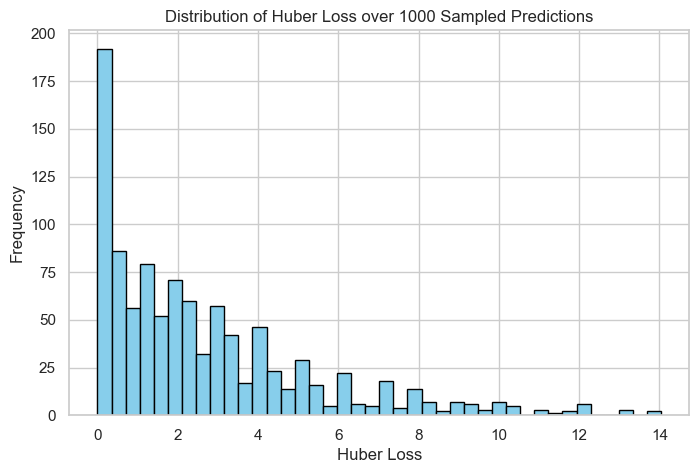

In [17]:
huber = HuberLoss(reduction='none')
losses = huber(preds, y_sample).cpu().numpy()

plt.figure(figsize=(8, 5))
plt.hist(losses, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Huber Loss")
plt.ylabel("Frequency")
plt.title("Distribution of Huber Loss over 1000 Sampled Predictions")
plt.grid(True)
plt.show()


In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Choose a player_api_id to visualize
player_id = player_cleaned_df['player_api_id'].iloc[0]  # You can change this to any valid player_api_id

# Get all rows for this player
player_df = player_cleaned_df[player_cleaned_df['player_api_id'] == player_id].reset_index(drop=True)

# Prepare input sequences for this player (skip first 'sequence_length' entries)
X_player = []
for i in range(len(player_df) - sequence_length):
    X_seq = player_df.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
    X_player.append(X_seq)
X_player_tensor = torch.tensor(np.stack(X_player)).to(device)

# Predict ratings
model.eval()
with torch.no_grad():
    preds = model(X_player_tensor).cpu().numpy().flatten()

# Actual ratings (skip first 'sequence_length' entries to align with predictions)
actual_ratings = player_df['overall_rating'].iloc[sequence_length:].to_numpy()

In [ ]:
def plot_player(player_id):
    player_df = player_cleaned_df[player_cleaned_df['player_api_id'] == player_id].reset_index(drop=True)
    X_player = []
    for i in range(len(player_df) - sequence_length):
        X_seq = player_df.loc[i:i+sequence_length-1, feature_cols].to_numpy(dtype=np.float32)
        X_player.append(X_seq)
    if len(X_player) == 0:
        print(f"Player {player_id} does not have enough records.")
        return
    X_player_tensor = torch.tensor(np.stack(X_player)).to(device)
    model.eval()
    with torch.no_grad():
        preds = model(X_player_tensor).cpu().numpy().flatten()
    actual_ratings = player_df['overall_rating'].iloc[sequence_length:].to_numpy()
    ages = player_df['age'].iloc[sequence_length:].to_numpy()
    y_min = min(actual_ratings.min(), preds.min())
    y_max = max(actual_ratings.max(), preds.max())
    if y_max - y_min < 15:
        center = (y_min + y_max) / 2
        y_lower = center - 7.5
        y_upper = center + 7.5
    else:
        y_lower = y_min
        y_upper = y_max
    plt.figure(figsize=(10, 5))
    plt.plot(ages, actual_ratings, label='Actual Rating', marker='o')
    plt.plot(ages, preds, label='Predicted Rating', marker='x')
    plt.xlabel('Age')
    plt.ylabel('Overall Rating')
    plt.title(f'Player {player_id} - Actual vs Predicted Ratings')
    plt.legend()
    plt.ylim(y_lower -1, y_upper+1)
    plt.show()

button = widgets.Button(description="Random Player")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        random_id = np.random.choice(player_cleaned_df['player_api_id'].unique())
        plot_player(random_id)

button.on_click(on_button_clicked)
display(button, output)

Button(description='Random Player', style=ButtonStyle())

Output()